In [32]:
import pandas as pd
import numpy as np
import tushare as ts
import datetime as dt
import os
from time import time
import matplotlib.pyplot as plt
from scipy import linalg
path = r'D:\factor\basic'
pd.options.display.float_format = '{:,.2f}'.format
# path = r'H:\data\factor\basic'
os.chdir(path)

# Prepare the test factor mom5

In [3]:
pctchg = pd.read_pickle('pct_chg.pkl').sort_index().fillna(0)
close = pd.read_pickle('close.pkl').sort_index()
adj = pd.read_pickle('adj_factor.pkl')
adj = adj.sort_index().reset_index().drop_duplicates(subset = 'index',keep = 'first').set_index(keys = 'index',drop = True)
adj = adj.loc[:,close.columns]
adjclo = close*adj
n = 5
mom5 = adjclo/adjclo.shift(1) - 1

startDay = '20110104'
endDay = '20211223'
factor = mom5.dropna(how = 'all')

# tinbar 

In [4]:
path = r'D:\factor'
# path = r'H:\data\factor'
os.chdir(path + r'\basic')
open = pd.read_pickle('open.pkl')
close = pd.read_pickle('close.pkl')
high = pd.read_pickle('high.pkl')
low = pd.read_pickle('low.pkl')

bar = abs(open-close)
uptin = (high*2-open-close-bar)/2
downtin = (open+close-2*low-bar)/2
#select downtin/bar>2
down2bar = downtin/bar
down2bar[down2bar<2] = np.nan
#select 60 and 00 stocks
cols = down2bar.columns
cols_judge = [x[:2]=='00' or x[:2]=='60' for x in cols]
cols = cols[cols_judge]
down2bar_selected = down2bar.loc[:,cols]

In [59]:
#下降趋势
day = '20210104'
daylist = close.index
temcols = down2bar_selected.loc[day,:].dropna().index
clo = close.loc[:,temcols]
clo = clo.iloc[-10:,:]
clo = clo.divide(clo.iloc[0,:],axis = 1)
n = len(clo)
A = np.matrix([range(n),np.ones(n)]).T
# pd.DataFrame((linalg.inv(A.T*A)*A.T*np.matrix(clo)).T,index = clo.columns,columns = ['k','b'])

In [57]:
def get_k(df):
    n = len(df)
    A = np.matrix([range(n),np.ones(n)]).T
    ansDf = pd.DataFrame((linalg.inv(A.T*A)*A.T*np.matrix(df)).T,index = df.columns,columns = ['k','b'])
    return ansDf.k

In [62]:
n = 10
for i,p in enumerate(close.index[0:100]):
    if i<n:
        continue
    clo = close.loc[daylist[i-10:i],down2bar_selected.loc[p,:].dropna().index] 

In [64]:
down2bar_selected.loc[p,:]

ts_code
000001.SZ    NaN
000002.SZ   4.00
000004.SZ   4.80
000005.SZ    NaN
000006.SZ   2.40
            ... 
603216.SH    NaN
001296.SZ    NaN
600941.SH    NaN
603176.SH    NaN
603230.SH    NaN
Name: 20110602, Length: 3205, dtype: float64

# Some functions

In [3]:
def ncut(series,n):
    if n==0:
        print('n = 1，fail')
        return
    try:
        label = list(range(n))
        cut = pd.qcut(series,n,labels = label)
        return cut
    except:
        print(str(n)+' fail,try '+str(n-1))
        return(ncut(series,n-1))

In [6]:
def describe_portfolio(cangwei,pct = pctchg,rf = 0.022):
    portfolioChg = (pct.loc[cangwei.index,cangwei.columns]*cangwei).sum(axis = 1)
    netvalue = (1+portfolioChg/100).cumprod()
    desDict = {}
    desDict['gain2loss'] = -(portfolioChg[portfolioChg>0]).mean()/(portfolioChg[portfolioChg<0]).mean()
    desDict['winrate'] = len(portfolioChg[portfolioChg>0])/len(portfolioChg)
    desDict['withdraw250'] = np.nanmax(1 - netvalue / netvalue.rolling(250).max())
    desDict['sharperatio'] =((netvalue[-1])**(250/len(netvalue))-1-rf)/np.nanstd(portfolioChg/100)/np.sqrt(250)
    return portfolioChg,netvalue,desDict

In [7]:
def get_ICs(factor,pct = pctchg,method ='default'):
    if method == 'rank_IC':
        factor = factor.rank(axis = 1)
        pctchg = pct.rank(axis = 1)
    factest = factor.dropna(how='all').dropna(how='all')
    pchg = pct.loc[factest.index, factest.columns]
    facmean = factest.T.sub(factest.mean(axis=1)).T
    pctmean = pchg.T.sub(pchg.mean(axis=1)).T
    pctmean = pctmean[facmean.notnull()]
    cov = np.diag(facmean.fillna(0).dot(pctmean.fillna(0).T))
    moment = (((facmean ** 2).sum(axis=1)) ** 0.5) * (((pctmean ** 2).sum(axis=1)) ** 0.5)
    return cov/moment



In [8]:
def describe_factor(fac,pct = pctchg,n= 10,rf = 0.022,lagperiod = 2):
    faclag = fac.shift(lagperiod)
    facBin = faclag.apply(ncut,args=(n,),axis = 1)
    positions = [(facBin==x)*1 for x in range(n)]
    positions = [p.divide(p.sum(axis = 1),axis = 0) for p in positions]
    pchgGroup = list(range(len(positions)))
    netvalueGroup =list(range(len(positions)))
    desGroup =list(range(len(positions)))
    indexlist = ['G'+str(x) for x in list(range(len(positions)))]
    for i,p in enumerate(positions):
        pchgGroup[i],netvalueGroup[i],desGroup[i] = describe_portfolio(p.dropna(how = 'all'),pct)
    pchgDf = pd.DataFrame(pchgGroup,index = indexlist)
    netvalueDf =pd.DataFrame(netvalueGroup,index = indexlist)
    desDf = pd.DataFrame(desGroup, index=indexlist)
    icSeries = get_ICs(faclag,pct)
    longshort = positions[-1] - positions[0]
    pchgls,netvaluels,desls= describe_portfolio(longshort.dropna(how = 'all'),pct)
    return pchgDf,netvalueDf,desDf,icSeries,netvaluels,desls

# Result show

In [27]:
# pchgDf,netvalueDf,defDf,icSeries,longshortvalue,longshortdes = describe_factor(down2bar,lagperiod = 1)


In [29]:
down2bar_selected.count(axis = 1)
pchgDf,netvalueDf,defDf,icSeries,longshortvalue,longshortdes = describe_factor(down2bar_selected,lagperiod = 1)


10 fail,try 9
9 fail,try 8
8 fail,try 7
7 fail,try 6
6 fail,try 5
5 fail,try 4
4 fail,try 3
3 fail,try 2
2 fail,try 1
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9


d:\python39\lib\site-packages\pandas\core\algorithms.py:1166: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction


10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
9 fail,try 8
8 fail,try 7
7 fail,try 6
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
9 fail,try 8
10 fail,try 9
10 fail,try 9
9 fail,try 8
8 fail,try 7
7 fail,try 6
10 fail,try 9
10 fail,try 9
9 fail,try 8
8 fail,try 7
10 fail,try 9
10 fail,try 9
10 fail,try 9
9 fail

{'gain2loss': 1.2279319310654395,
 'winrate': 0.5862977602108037,
 'withdraw250': 0.13995142859817677,
 'sharperatio': 2.9021321362693713}

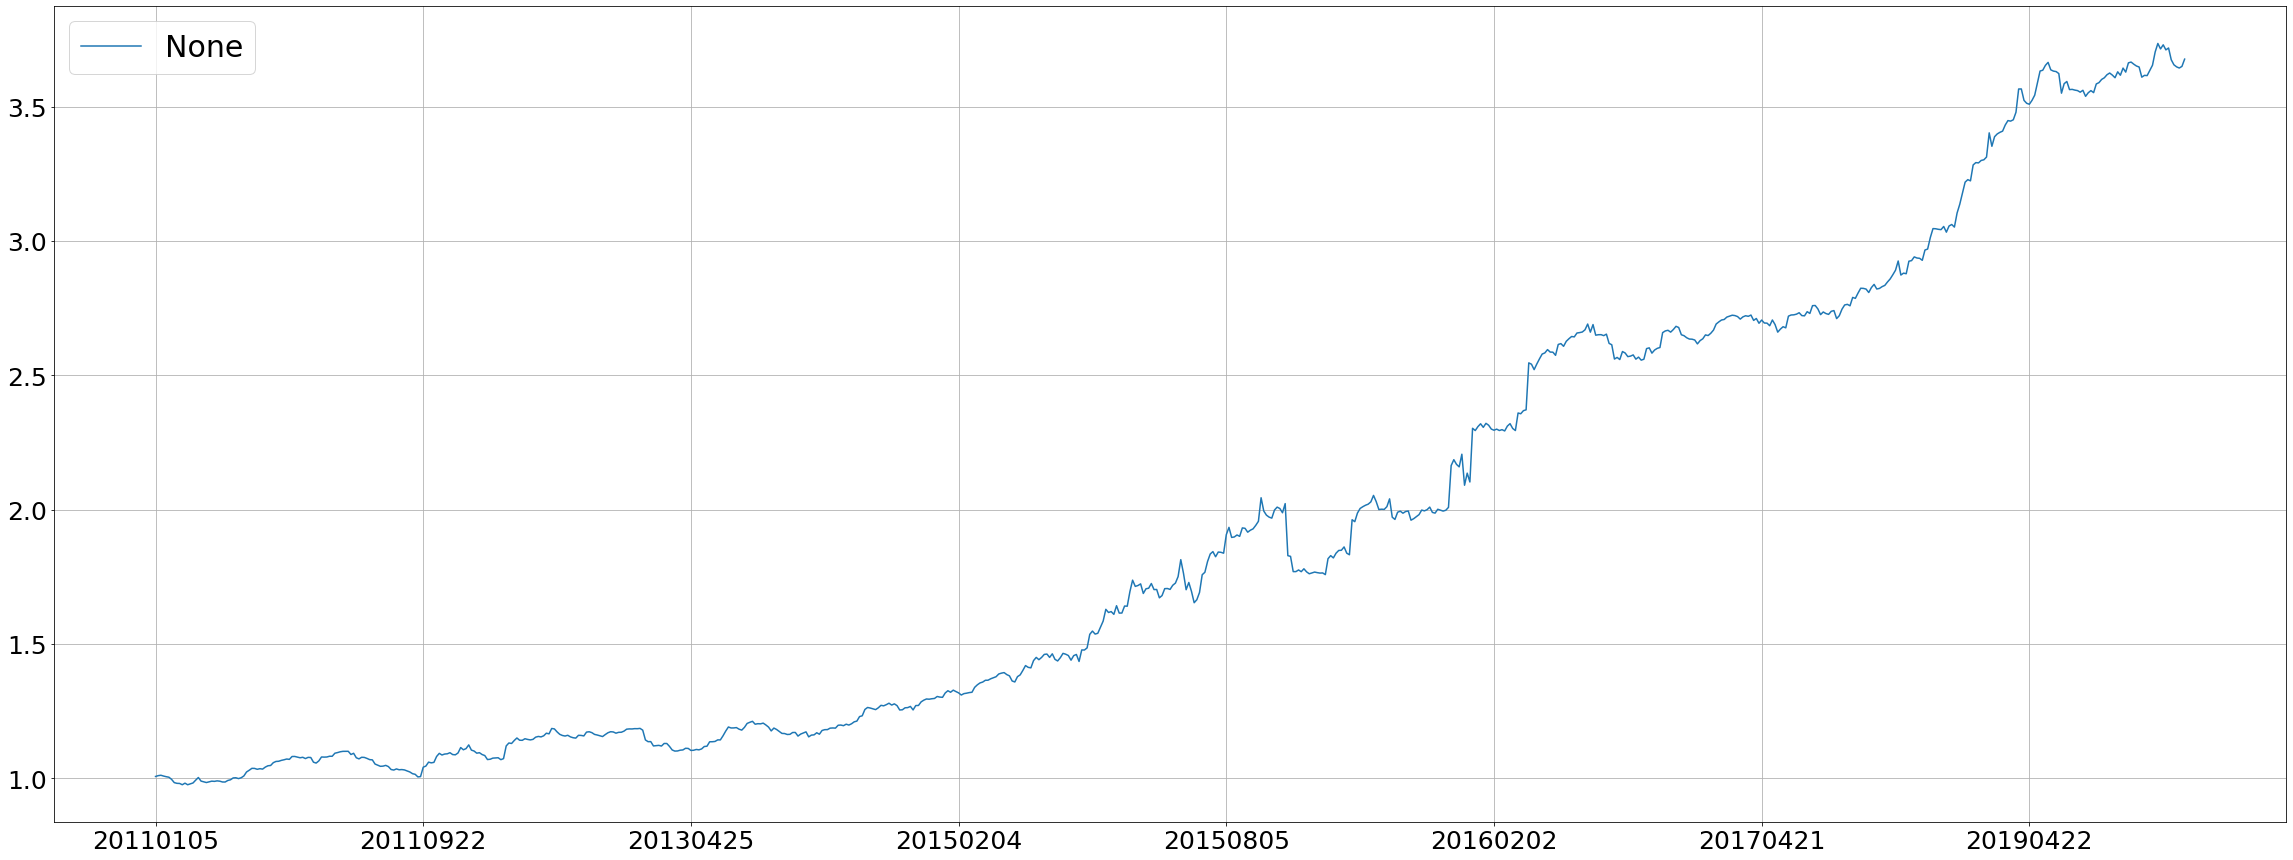

In [30]:
longshortvalue.T.plot(grid = 'on',figsize = (40,15),fontsize = 25)
plt.legend(loc=2, prop={'size': 30})
longshortdes

,gain2loss,winrate,withdraw250,sharperatio
G0,0.89,0.54,0.51,0.05
G1,0.90,0.54,0.56,-0.02
G2,0.91,0.54,0.50,0.12
G3,0.90,0.53,0.57,-0.08
G4,0.90,0.54,0.54,-0.01
G5,0.88,0.55,0.48,0.06
G6,0.89,0.55,0.50,0.24
G7,0.87,0.56,0.50,0.23
G8,0.90,0.57,0.51,0.83
G9,0.92,0.61,0.37,2.59


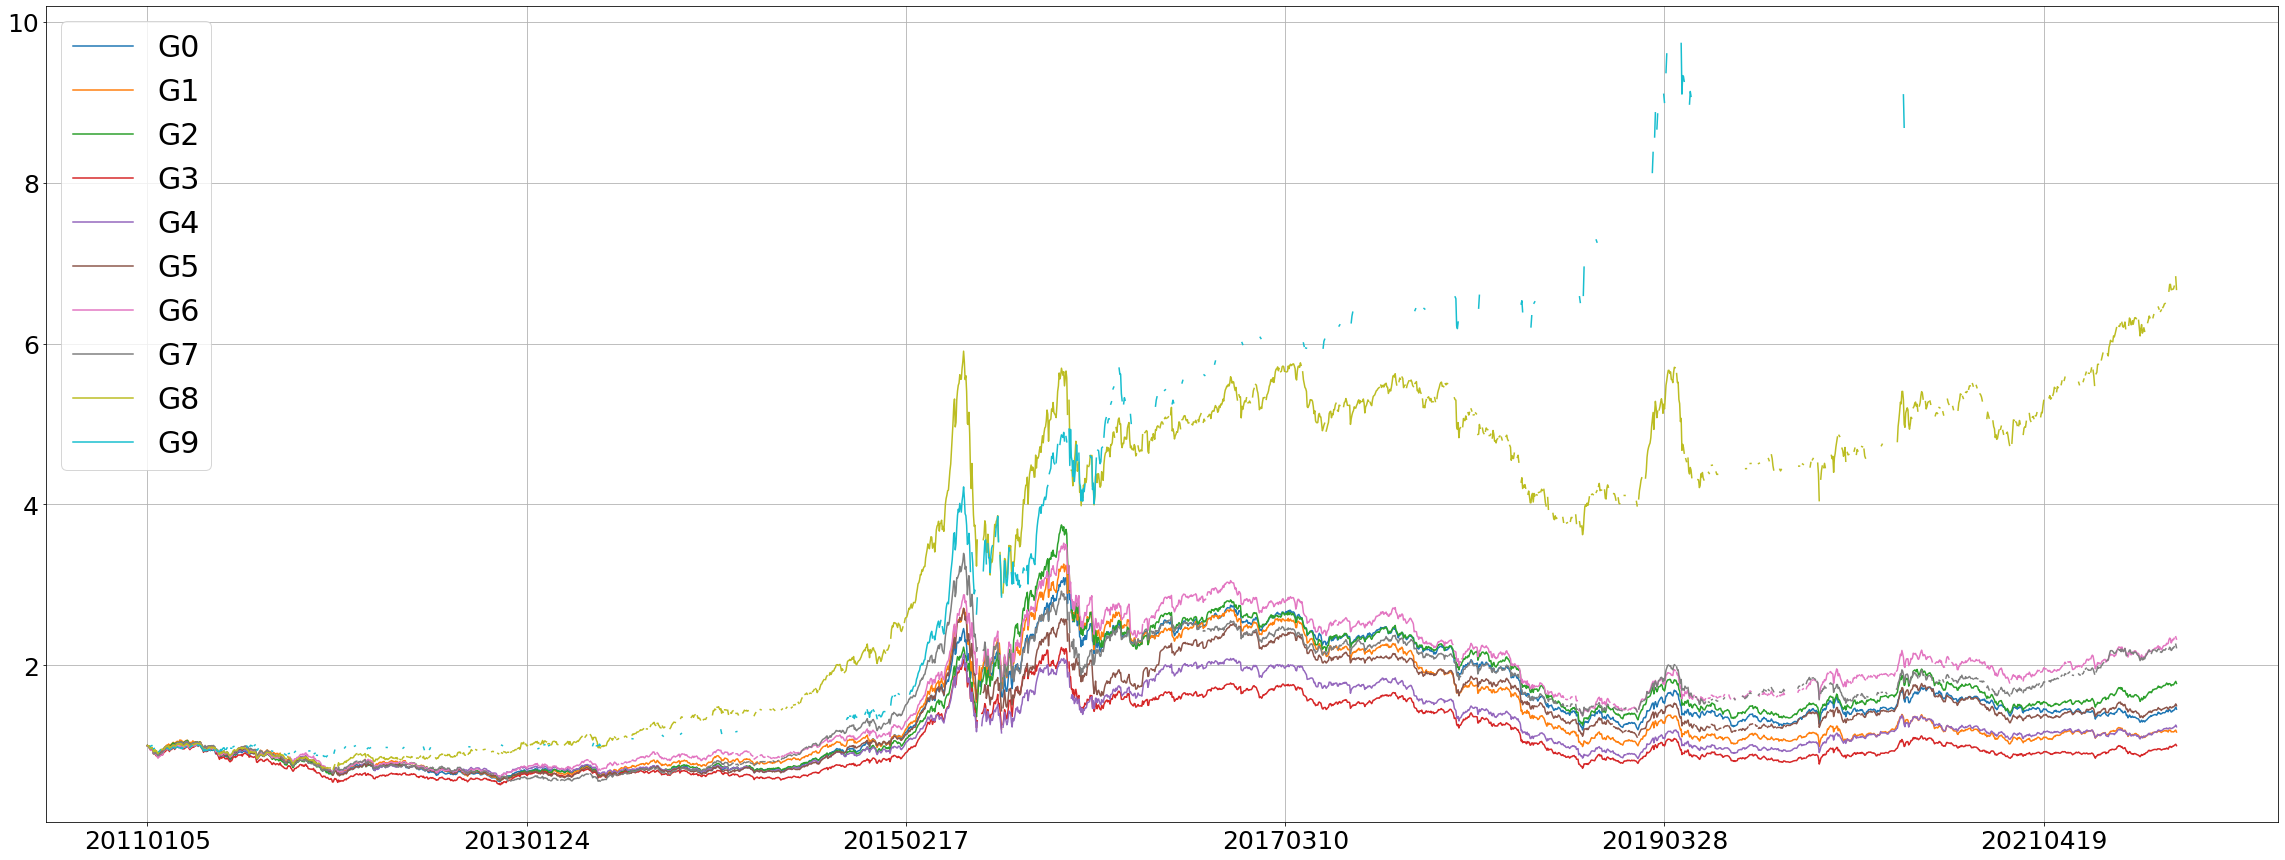

In [31]:
netvalueDf.T.plot(grid = 'on',figsize = (40,15),fontsize = 25)
plt.legend(loc=2, prop={'size': 30})
display(defDf)

ic_mean   0.10
ic_std    0.53
ir        0.20
ic>0.02   0.50
dtype: float64

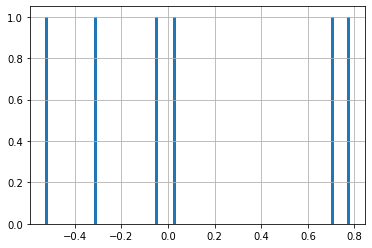

In [32]:
icSeries.hist(bins = 100)
pd.Series([icSeries.mean(),icSeries.std(),icSeries.mean()/icSeries.std(),(icSeries[icSeries*icSeries.mean()/(abs(icSeries.mean()))>0.02]).count()/icSeries.count()],
          index = ['ic_mean','ic_std','ir','ic>0.02'])


In [33]:
pctchg.iloc[-50:,:]

ts_code,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,301190.SZ,600941.SH,603176.SH,603230.SH,688167.SH,688206.SH,688210.SH,688227.SH,688236.SH,688265.SH
20211027,-0.65,-0.30,-6.79,-1.79,-1.89,1.45,-1.77,-0.10,4.46,-2.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211028,-1.00,-2.70,0.43,-0.91,-1.69,-0.95,-3.15,3.51,0.00,-1.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211029,-1.12,-4.81,1.57,0.92,2.21,5.04,1.40,-2.97,-1.00,0.27,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211101,-0.56,-0.11,0.30,-1.37,-0.24,5.02,-0.46,-1.96,2.03,-3.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211102,-6.24,-3.02,-2.67,-4.17,-1.92,1.09,-1.38,-3.95,-2.99,-1.88,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211103,-0.83,2.32,2.07,0.97,0.98,4.95,-0.47,-3.20,0.77,0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211104,-0.89,0.06,0.42,0.00,0.00,4.71,-0.94,3.31,-0.51,0.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211105,-1.29,-1.33,2.26,-0.48,-0.73,-2.74,0.00,-6.60,-1.53,-1.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211108,-1.25,2.75,0.29,2.40,0.00,5.03,-0.47,10.01,-2.34,-0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20211109,0.63,-0.49,1.97,0.47,0.00,4.98,0.95,1.09,2.13,0.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
